# MSBA 446 - Homework 2
# Detecting COVID-19 from Chest CT Scans


As the Coronavirus Disease 2019 (COVID-19) pandemic continues to grow globally, testing to detect COVID-19 and isolating individuals who test positive remains to be the primary strategy for preventing community spread of the disease. The current gold standard method of testing for COVID-19 is the reverse transcription polymerase chain reaction (RT-PCR) test. The RT-PCR test, however, has an imperfect sensitivity (around 70%) and is in short supply, particularly in resource-limited countries. Therefore, automatic and accurate detection of COVID-19 using medical imaging modalities, such as Computed Tomography (CT), can be beneficial as an alternative diagnostic tool.

In this exercise, our goal is to develop Convolutional Neural Networks to automatically detect the subtle signs of COVID-19 infection in patients' lungs from CT images. Our dataset contains 1010 CT scans from individuals with COVID-19 and 1010 CT scans from patients with other pulmonary diseases (non-COVID-19). These data have been collected from real patients in hospitals from Sao Paulo, Brazil. 

Our training and validation sets include 1600 and 420 CT images, respectively (half COVID-19, half non-COVID-19). Given the small size of the original dataset, I did not set aside any images for the test set. We will use the validation accuracy to evaluate our models. This is OK since we are not going to use the validation performance as a feedback signal to fine tune the hyperparameters of our models. 

Your task is to classify the images correctly by building multiple CNNs and comparing their performance.

Here are what a few of the CT images look like:

![ct-covid](https://www.dropbox.com/s/r9lld9dj7875rsw/ct-covid.jpg?dl=1)


## Note on training time

I recommend you train your CNNs on GPU for faster training. To do so, from the Runtime tab above, go to Change runtime type and select GPU as Hardware accelerator. Training time of each model may take up to an hour on GPU (longer on CPU), so please be patient.

## Load the data

First, add the `covid19_ct` folder from [here](https://drive.google.com/drive/folders/11-2z9P45FtJJPm9LbipVMAnNZ36kMQUH) to your Google Drive. For example, you can drag and drop the `covid19_ct` folder into your "My Drive"; this will add a shortcut to the original folder in your "My Drive". By doing so, you can run your code directly on the data that are stored on my Google Drive account without the need to download the images and upload them to your Drive. 

Mount your Google Drive and load the data. Be sure to change the directory path provided below to your own data path.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Mounted at /content/drive


In [ ]:
# Define directories of where the training and validation sets reside
base_dir = '/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Datasets/covid19_ct'
# This is the path to where my files are - your path will be different

In [ ]:
import os

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Training Data
train_covid  = os.path.join(train_dir, 'COVID')
train_noncovid     = os.path.join(train_dir, 'non-COVID')

# Validation Data
val_covid  = os.path.join(validation_dir, 'COVID')
val_noncovid     = os.path.join(validation_dir, 'non-COVID')


Use the code below to check how many images are available for each class in the training and validation sets.

In [ ]:
print('Total training covid images:', len(os.listdir(train_covid)))
print('Total training noncovid images:', len(os.listdir(train_noncovid)))

Total training covid images: 800
Total training noncovid images: 800


In [ ]:
print('Total validation covid images:', len(os.listdir(val_covid)))
print('Total validation noncovid images:', len(os.listdir(val_noncovid)))

Total validation covid images: 210
Total validation noncovid images: 210


## Question 1. Build a simple CNN from scratch (50 pts)

Build a simple CNN. Include 3 convolution and 3 max-pooling layers. In convolution layers 1, 2, and 3, include 32, 64, and 64 filters, respectively. Use 3x3 filters, 2x2 pooling windows, and ReLU activation functions. Please use an input shape of 64x64 and note that while these images look like greyscale images, they are in fact color images. Include a dense layer with 128 nodes on top along with an appropriate output layer. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training. (hint: if you do not recall how to change the default learning rate of your optimizer, check out Module 1 slides.)

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. Create `train_datagen` and `validation_datagen` generators that rescale the images appropriately. Do not do any data augmentation in your first model (that will come next!) 
Then, define a training set generator and validation set generator using the generators `train_datagen` and `validation_datagen` and the `.flow_from_directory` method. Specify the `target_size` (it should match the input size above), set the `batch_size` to 32 and choose an appropriate `class_mode`. Train the model for 50 epochs. 

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()

# Add 3 convolution layer 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))) # (64, 64, 3) : color image
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu')) # Flattern layer

model.add(layers.Dense(1, activation='sigmoid')) # Output layer


model.compile(optimizer=optimizers.RMSprop(learning_rate = 0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the directory where our training data reside
        train_dir,
        # We want all images to be resized to 150x150
        target_size=(64, 64),
        # Telling the data generator to prepare data in batches of size 20
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        # Note: If our problem was a multi-class single-label classification, 
        # we would use categorical_crossentropy loss and set class_mode to 'categorical'

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
model_history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
50/50 [==============================] - 354s 7s/step - loss: 0.6783 - accuracy: 0.6094 - val_loss: 0.6571 - val_accuracy: 0.6024
Epoch 2/50
50/50 [==============================] - 12s 232ms/step - loss: 0.6528 - accuracy: 0.6600 - val_loss: 0.6262 - val_accuracy: 0.7119
Epoch 3/50
50/50 [==============================] - 12s 236ms/step - loss: 0.6225 - accuracy: 0.6963 - val_loss: 0.5792 - val_accuracy: 0.7810
Epoch 4/50
50/50 [==============================] - 12s 237ms/step - loss: 0.5929 - accuracy: 0.7106 - val_loss: 0.5515 - val_accuracy: 0.7548
Epoch 5/50
50/50 [==============================] - 12s 236ms/step - loss: 0.5644 - accuracy: 0.7350 - val_loss: 0.5072 - val_accuracy: 0.8000
Epoch 6/50
50/50 [==============================] - 12s 231ms/step - loss: 0.5381 - accuracy: 0.7563 - val_loss: 0.4927 - val_accuracy: 0.7810
Epoch 7/50
50/50 [==============================] - 12s 238ms/step - loss: 0.5122 - accuracy: 0.7731 - val_loss: 0.4858 - val_accuracy: 0.7738
E

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


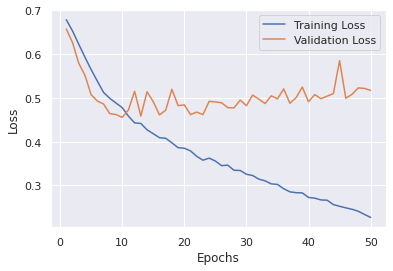

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc  = model_history.history['accuracy']
train_loss = model_history.history['loss']
val_acc  = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

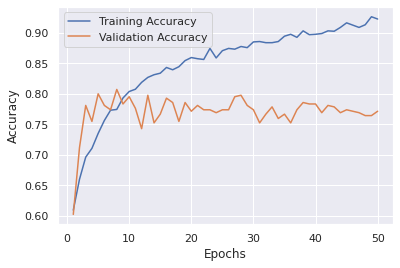

In [ ]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
model.save('/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Homework/HW2/covid19_ct_model.h5')


The model is definitely **overfitting**. The validation loss reaches minimum at epoch10 and then it increases while training loss keeps decreasing to almost 0 by epoch50. The training accuracy increases overtime, which reaches approx 100% by epoch 50. But validation accuracy stalls at 75-80%. 

## Question 2. Use transfer learning and data augmentation to improve your CNN (50 pts)

Use one of the pre-trained models in Keras that has been trained on the ImageNet dataset (e.g., VGG16) as your convolutional base. Add a densly-connected layer and an output layer with the same number of neurons and the same activation functions as in your previous model to this convolutional base. Make sure to freeze the convolutional base so that the pre-trained weights and biases do not change during the training process of the new densly-connected classifier. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training. 

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. This time use the tool to do data augmentation. You are free to choose the type of transformations made to the training images, or you can just use the same data augmentation parameters we used in class for the cat vs. dog example. Keep the same target size and batch size as your previous model. 
Train your model for 100 epochs. 

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

Compare the validation loss and accuracy of the two models you developed in this notebook. Which model would you choose to detect COVID-19 from chest CT images? 

Make sure you run all of your code so that the output of each code block appears below it.  Once you are done, download your final `.ipynb` file (File -> Download .ipynb) and submit it on Canvas. Name your file as follows: LastName_FirstName_HW2.ipynb

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model2 = models.Sequential()

model2.add(conv_base)

model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False # Freezing the convolutional base

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255

# Define the data augmentation parameters in ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

# Note that the validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the directory where our training data reside
        train_dir,
        # We want all images to be resized to 150x150
        target_size=(64, 64),
        # Telling the data generator to prepare data in batches of size 20
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        # Note: If our problem was a multi-class single-label classification, 
        # we would use categorical_crossentropy loss and set class_mode to 'categorical'

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate = 0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2_history = model2.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

Epoch 1/100
50/50 [==============================] - 14s 273ms/step - loss: 0.6619 - accuracy: 0.6006 - val_loss: 0.5926 - val_accuracy: 0.6571
Epoch 2/100
50/50 [==============================] - 13s 266ms/step - loss: 0.6051 - accuracy: 0.6894 - val_loss: 0.5621 - val_accuracy: 0.7071
Epoch 3/100
50/50 [==============================] - 14s 277ms/step - loss: 0.5679 - accuracy: 0.7175 - val_loss: 0.5861 - val_accuracy: 0.6690
Epoch 4/100
50/50 [==============================] - 13s 264ms/step - loss: 0.5496 - accuracy: 0.7287 - val_loss: 0.5348 - val_accuracy: 0.7310
Epoch 5/100
50/50 [==============================] - 13s 257ms/step - loss: 0.5277 - accuracy: 0.7469 - val_loss: 0.5088 - val_accuracy: 0.7619
Epoch 6/100
50/50 [==============================] - 13s 259ms/step - loss: 0.5121 - accuracy: 0.7544 - val_loss: 0.5103 - val_accuracy: 0.7548
Epoch 7/100
50/50 [==============================] - 14s 270ms/step - loss: 0.5000 - accuracy: 0.7531 - val_loss: 0.5127 - val_accuracy:

In [ ]:
model2.save('/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Homework/HW2/covid19_ct_model2.h5')


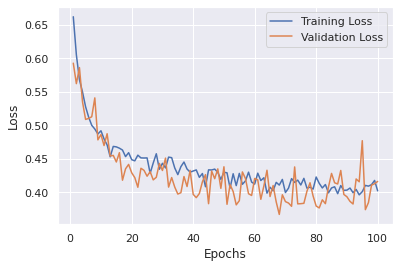

In [ ]:
train_acc2  = model2_history.history['accuracy']
train_loss2 = model2_history.history['loss']
val_acc2  = model2_history.history['val_accuracy']
val_loss2 = model2_history.history['val_loss']

epochs = range(1, len(train_acc2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

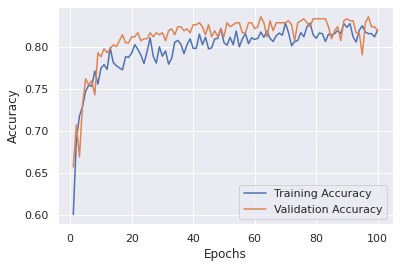

In [ ]:
plt.plot(epochs, train_acc2, label = 'Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

The model is **not overfitting**. The valudation curves, both accuracy and loss, are closely following the training curves. Data augmentation allowed us to train the model with larger input files. 

In [ ]:
epochs1 = range(1, len(train_acc) + 1)
epochs2 = range(1, len(train_acc2) + 1)

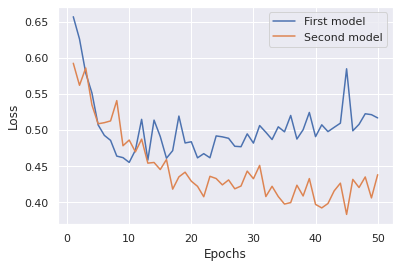

In [ ]:
plt.plot(epochs1, val_loss, label = 'First model')
plt.plot(epochs2[:50], val_loss2[:50], label = 'Second model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

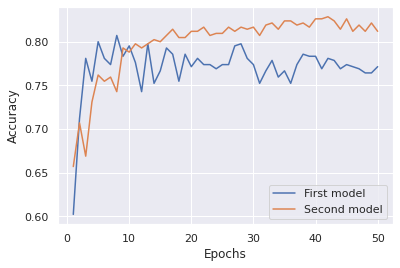

In [ ]:
plt.plot(epochs1, val_acc, label = 'First model')
plt.plot(epochs2[:50], val_acc2[:50], label = 'Second model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

The above 2 graphs shows comparision between first and second model. We can see that second model which was built using transfer learning and data augmentation is significantly better than first model. Validation loss is constantly decreasing and validataion accuracy is constantly increasing for second model. I would choose second model to detect COVID-19 from chest CT images. 

VGG19

Found 1600 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Epoch 1/100
50/50 [==============================] - 13s 252ms/step - loss: 0.6590 - accuracy: 0.6194 - val_loss: 0.6380 - val_accuracy: 0.5833
Epoch 2/100
50/50 [==============================] - 12s 245ms/step - loss: 0.6113 - accuracy: 0.6787 - val_loss: 0.5951 - val_accuracy: 0.6571
Epoch 3/100
50/50 [==============================] - 12s 241ms/step - loss: 0.5614 - accuracy: 0.7412 - val_loss: 0.5905 - val_accuracy: 0.6619
Epoch 4/100
50/50 [==============================] - 12s 243ms/step - loss: 0.5530 - accuracy: 0.7194 - val_loss: 0.5795 - val_accuracy: 0.6952
Epoch 5/100
50/50 [==============================] - 13s 259ms/step - loss: 0.5433 - accuracy: 0.7312 - val_loss: 0.5423 - val_accuracy: 0.7619
Epoch 6/100
50/50 [==============================] - 12s 243ms/step - loss: 0.5092 - accuracy: 0.7694 - val_loss: 0.5296 - val_accuracy: 0.7619
Epoch 7/100
50/50 [==============================] - 

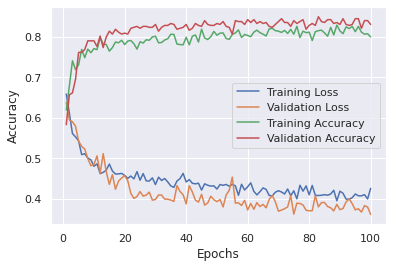

In [ ]:
from tensorflow.keras.applications import VGG19

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

model3 = models.Sequential()

model3.add(conv_base)

model3.add(layers.Flatten())

model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False # Freezing the convolutional base

# All images will be rescaled by 1./255

# Define the data augmentation parameters in ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

# Note that the validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the directory where our training data reside
        train_dir,
        # We want all images to be resized to 150x150
        target_size=(64, 64),
        # Telling the data generator to prepare data in batches of size 20
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        # Note: If our problem was a multi-class single-label classification, 
        # we would use categorical_crossentropy loss and set class_mode to 'categorical'

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

model3.compile(optimizer=optimizers.RMSprop(learning_rate = 0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3_history = model3.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

model3.save('/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Homework/HW2/covid19_ct_model3.h5')


train_acc3  = model3_history.history['accuracy']
train_loss3 = model3_history.history['loss']
val_acc3  = model3_history.history['val_accuracy']
val_loss3 = model3_history.history['val_loss']

epochs = range(1, len(train_acc3) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.plot(epochs, train_acc3, label = 'Training Accuracy')
plt.plot(epochs, val_acc3, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

model4 = models.Sequential()

model4.add(conv_base)

model4.add(layers.Flatten())

model4.add(layers.Dense(128, activation='relu'))
model34.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False # Freezing the convolutional base

# All images will be rescaled by 1./255

# Define the data augmentation parameters in ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

# Note that the validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the directory where our training data reside
        train_dir,
        # We want all images to be resized to 150x150
        target_size=(64, 64),
        # Telling the data generator to prepare data in batches of size 20
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        # Note: If our problem was a multi-class single-label classification, 
        # we would use categorical_crossentropy loss and set class_mode to 'categorical'

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

model4.compile(optimizer=optimizers.RMSprop(learning_rate = 0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4_history = model4.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

model4.save('/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Homework/HW2/covid19_ct_model4.h5')


train_acc4  = model4_history.history['accuracy']
train_loss4 = model4_history.history['loss']
val_acc4  = model4_history.history['val_accuracy']
val_loss4 = model4_history.history['val_loss']

epochs = range(1, len(train_acc4) + 1)

plt.plot(epochs, train_loss4, label = 'Training Loss')
plt.plot(epochs, val_loss4, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.plot(epochs, train_acc4, label = 'Training Accuracy')
plt.plot(epochs, val_acc4, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


Xception

InceptionV3

ResNet50